## Applied ML for baseball:

#### By Thomas Maxence Franco 
Submitted to the Faculty of Science in partial fulfillment of the requirements for the degree of 
#### Master of Modeling for Science and Engineering 
at the 
#### UNIVERSITAT AUTÒNOMA DE BARCELONA 
Directed by 
Tomás Manuel Margalef Burrull
July 2024


In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [2]:
file_path = "C:\\Users\\mfran\\OneDrive - UAB\\Masters\\Thesis\\Batting\\tables\\advperf_all.csv"
df = pd.read_csv(file_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 61 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              420 non-null    object 
 1   AAV               420 non-null    float64
 2   catcher           420 non-null    bool   
 3   year              420 non-null    int64  
 4   Age               420 non-null    int64  
 5   stayed_same_team  420 non-null    bool   
 6   G                 420 non-null    int64  
 7   PA                420 non-null    int64  
 8   HR                420 non-null    int64  
 9   R                 420 non-null    int64  
 10  RBI               420 non-null    int64  
 11  AVG               420 non-null    float64
 12  OBP               420 non-null    float64
 13  SLG               420 non-null    float64
 14  GDP               420 non-null    int64  
 15  H                 420 non-null    int64  
 16  OPS               420 non-null    float64
 1

In [4]:
df.head()

,Name,AAV,catcher,year,Age,stayed_same_team,G,PA,HR,R,...,BsR_2,WAR_2,wRAA_2,UBR_2,WPA_2,Clutch_2,Barrel%_2,HardHit%_2,xBA_2,xSLG_2
0,Shohei Ohtani,35.122807,False,2024,29,False,135,599,44,102,...,-1.666291,3.607169,31.681486,0.2,2.110040,-0.410867,0.168224,0.497664,0.275,0.549
1,Cody Bellinger,26.666667,False,2024,28,True,130,556,26,95,...,2.793818,1.489862,-11.230229,2.7,-1.326695,-0.436589,0.083333,0.380556,0.213,0.354
2,Teoscar Hernandez,23.500000,False,2024,31,False,160,678,26,70,...,0.522415,2.920516,16.154087,0.2,0.921679,0.530959,0.149856,0.527378,0.265,0.501
3,Matt Chapman,18.000000,False,2024,31,False,140,581,17,66,...,1.042438,3.891624,10.354405,2.2,0.159277,-0.651814,0.128686,0.506702,0.234,0.440
4,Rhys Hoskins,17.000000,False,2024,31,False,0,0,0,0,...,-2.598383,2.366255,18.912618,-2.6,1.471186,-0.352039,0.110588,0.442353,0.239,0.445


## Data Cleaning

Missing values for Barrel%_2, HardHit%_2, xBA_2, xSLG_2 are due to the lack of Statcast equipment for the 2014 and previous season to that. To not lose 59 rows of valuable info I will use the stats we have for those columns from the 2015 season. There is no real variance in them from season to season as the next lines of code will show:

In [5]:
df['Barrel_diff'] = df['Barrel%'] - df['Barrel%_2']

In [6]:
average_diff = df['Barrel_diff'].mean()
print("Average Difference: ", average_diff)

Average Difference:  0.003107339103641457


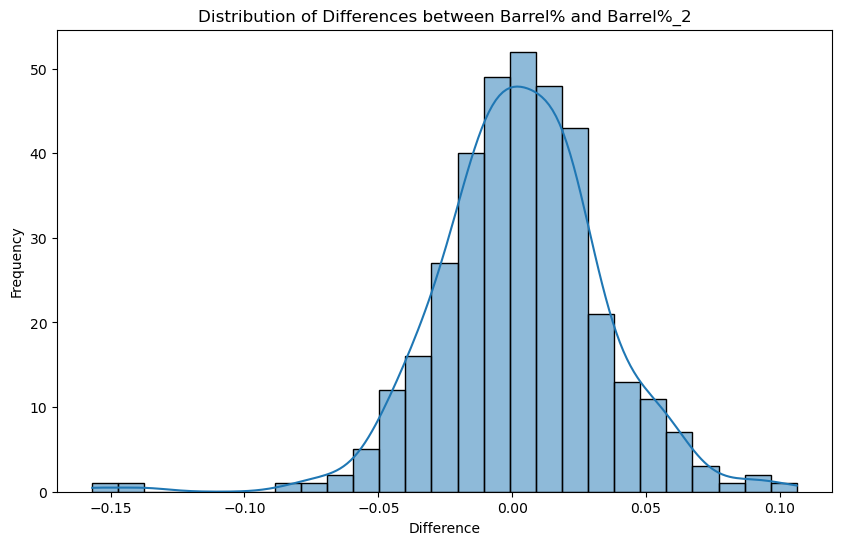

In [7]:
# Detailed distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(df['Barrel_diff'], kde=True)
plt.title('Distribution of Differences between Barrel% and Barrel%_2')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

In [8]:
df['HardHit_diff'] = df['HardHit%'] - df['HardHit%_2']
average_diffhh = df['HardHit_diff'].mean()
print("Average Difference: ", average_diffhh)

Average Difference:  0.005074780392156861


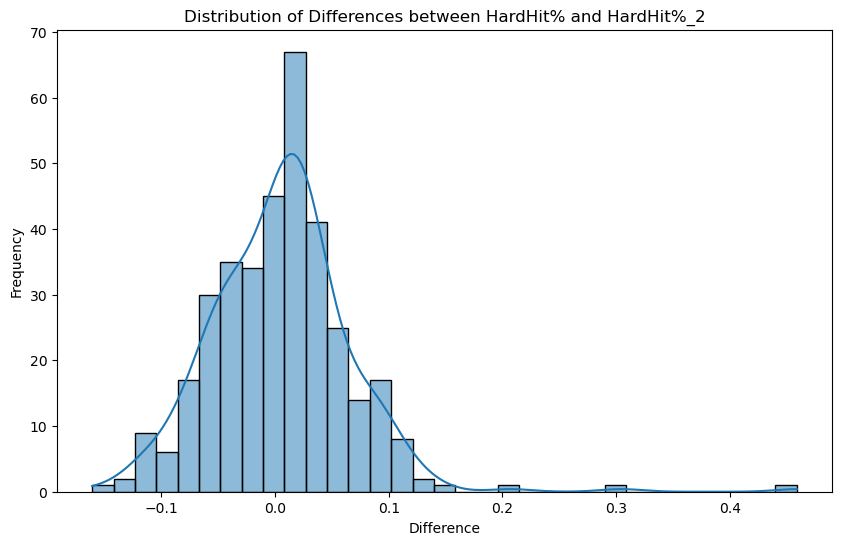

In [9]:
# Detailed distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(df['HardHit_diff'], kde=True)
plt.title('Distribution of Differences between HardHit% and HardHit%_2')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

In [10]:
df['xBA_diff'] = df['xBA'] - df['xBA_2']
average_xBA = df['xBA_diff'].mean()
print("Average Difference: ", average_xBA)

Average Difference:  -0.0027002801120448176


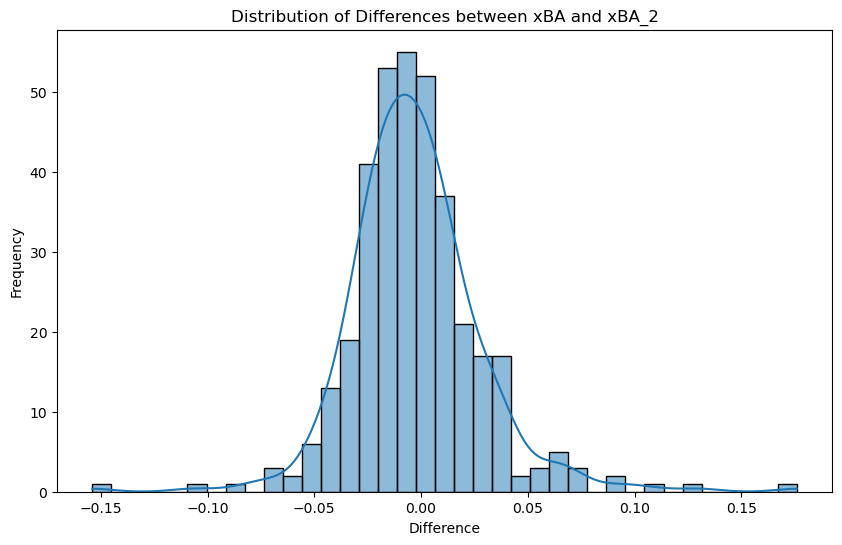

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(df['xBA_diff'], kde=True)
plt.title('Distribution of Differences between xBA and xBA_2')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

In [12]:
df['xSLG_diff'] = df['xSLG'] - df['xSLG_2']
average_xSLG = df['xSLG_diff'].mean()
print("Average Difference: ", average_xSLG)

Average Difference:  -0.0036218487394958014


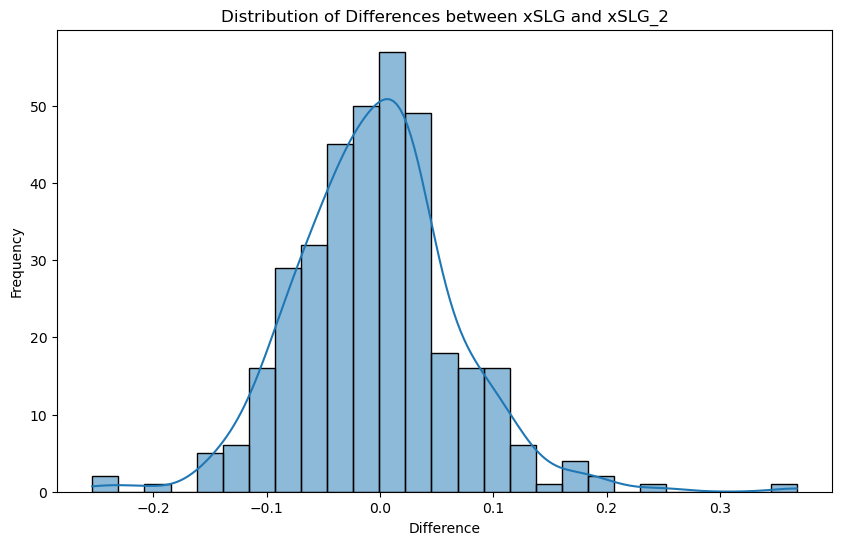

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df['xSLG_diff'], kde=True)
plt.title('Distribution of Differences between xSLG and xSLG_2')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

In [14]:
columns_to_drop = ['Barrel_diff', 'HardHit_diff', 'xBA_diff', 'xSLG_diff']

df.drop(columns=columns_to_drop, inplace=True)

In [15]:
columns_to_fill = ['Barrel%_2', 'HardHit%_2', 'xBA_2', 'xSLG_2']
corresponding_columns = ['Barrel%', 'HardHit%', 'xBA', 'xSLG']

rows_with_missing_values=df[df[columns_to_fill].isnull().any(axis=1)]
relevant_columns = columns_to_fill + corresponding_columns


print(rows_with_missing_values[relevant_columns])


     Barrel%_2  HardHit%_2  xBA_2  xSLG_2   Barrel%  HardHit%    xBA   xSLG
209        NaN         NaN    NaN     NaN  0.072539  0.409326  0.251  0.485
303        NaN         NaN    NaN     NaN  0.014085  0.225352  0.268  0.353
361        NaN         NaN    NaN     NaN  0.104628  0.448692  0.294  0.546
362        NaN         NaN    NaN     NaN  0.167568  0.462162  0.262  0.589
363        NaN         NaN    NaN     NaN  0.028139  0.346320  0.263  0.374
..         ...         ...    ...     ...       ...       ...    ...    ...
415        NaN         NaN    NaN     NaN  0.014493  0.275362  0.205  0.293
416        NaN         NaN    NaN     NaN  0.079235  0.311475  0.238  0.435
417        NaN         NaN    NaN     NaN  0.000000  0.178808  0.231  0.285
418        NaN         NaN    NaN     NaN  0.093023  0.372093  0.186  0.335
419        NaN         NaN    NaN     NaN  0.000000  0.203704  0.262  0.322

[61 rows x 8 columns]


In [16]:
for col_to_fill, corresponding_col in zip(columns_to_fill, corresponding_columns):
    df[col_to_fill] = df[col_to_fill].fillna(df[corresponding_col])


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 61 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              420 non-null    object 
 1   AAV               420 non-null    float64
 2   catcher           420 non-null    bool   
 3   year              420 non-null    int64  
 4   Age               420 non-null    int64  
 5   stayed_same_team  420 non-null    bool   
 6   G                 420 non-null    int64  
 7   PA                420 non-null    int64  
 8   HR                420 non-null    int64  
 9   R                 420 non-null    int64  
 10  RBI               420 non-null    int64  
 11  AVG               420 non-null    float64
 12  OBP               420 non-null    float64
 13  SLG               420 non-null    float64
 14  GDP               420 non-null    int64  
 15  H                 420 non-null    int64  
 16  OPS               420 non-null    float64
 1

In [18]:
corresponding_columns  = ['Barrel%_2', 'HardHit%_2', 'xBA_2', 'xSLG_2']
columns_to_fill = ['Barrel%', 'HardHit%', 'xBA', 'xSLG']
for col_to_fill, corresponding_col in zip(columns_to_fill, corresponding_columns):
    df[col_to_fill] = df[col_to_fill].fillna(df[corresponding_col])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 61 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              420 non-null    object 
 1   AAV               420 non-null    float64
 2   catcher           420 non-null    bool   
 3   year              420 non-null    int64  
 4   Age               420 non-null    int64  
 5   stayed_same_team  420 non-null    bool   
 6   G                 420 non-null    int64  
 7   PA                420 non-null    int64  
 8   HR                420 non-null    int64  
 9   R                 420 non-null    int64  
 10  RBI               420 non-null    int64  
 11  AVG               420 non-null    float64
 12  OBP               420 non-null    float64
 13  SLG               420 non-null    float64
 14  GDP               420 non-null    int64  
 15  H                 420 non-null    int64  
 16  OPS               420 non-null    float64
 1

The same thought process wll be done for the other columns

In [19]:
columns_to_fill = ["BABIP","wOBA","wRC+","Off","Def","BsR","WAR","wRAA","UBR","WPA","Clutch"]
corresponding_columns = ["BABIP_2","wOBA_2","wRC+_2","Off_2","Def_2","BsR_2","WAR_2","wRAA_2","UBR_2","WPA_2","Clutch_2"]

rows_with_missing_values=df[df[columns_to_fill].isnull().any(axis=1)]
relevant_columns = columns_to_fill + corresponding_columns


print(rows_with_missing_values[relevant_columns])

     BABIP  wOBA  wRC+  Off  Def  BsR  WAR  wRAA  UBR  WPA  ...    wOBA_2  \
4      NaN   NaN   NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...  0.345172   
227    NaN   NaN   NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...  0.299453   

         wRC+_2      Off_2      Def_2     BsR_2     WAR_2     wRAA_2  UBR_2  \
4    122.328017  14.834363 -15.319128 -2.598383  2.366255  18.912618   -2.6   
227   84.442374  -5.020572  -4.698701  0.145992 -0.142697  -3.380756    0.4   

        WPA_2  Clutch_2  
4    1.471186 -0.352039  
227 -0.633888 -0.034693  

[2 rows x 22 columns]


In [20]:
for col_to_fill, corresponding_col in zip(columns_to_fill, corresponding_columns):
    df[col_to_fill] = df[col_to_fill].fillna(df[corresponding_col])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 61 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              420 non-null    object 
 1   AAV               420 non-null    float64
 2   catcher           420 non-null    bool   
 3   year              420 non-null    int64  
 4   Age               420 non-null    int64  
 5   stayed_same_team  420 non-null    bool   
 6   G                 420 non-null    int64  
 7   PA                420 non-null    int64  
 8   HR                420 non-null    int64  
 9   R                 420 non-null    int64  
 10  RBI               420 non-null    int64  
 11  AVG               420 non-null    float64
 12  OBP               420 non-null    float64
 13  SLG               420 non-null    float64
 14  GDP               420 non-null    int64  
 15  H                 420 non-null    int64  
 16  OPS               420 non-null    float64
 1

In [22]:
corresponding_columns = ["BABIP","wOBA","wRC+","Off","Def","BsR","WAR","wRAA","UBR","WPA","Clutch"]
columns_to_fill= ["BABIP_2","wOBA_2","wRC+_2","Off_2","Def_2","BsR_2","WAR_2","wRAA_2","UBR_2","WPA_2","Clutch_2"]

rows_with_missing_values=df[df[columns_to_fill].isnull().any(axis=1)]
relevant_columns = columns_to_fill + corresponding_columns


print(rows_with_missing_values[relevant_columns])

     BABIP_2  wOBA_2  wRC+_2  Off_2  Def_2  BsR_2  WAR_2  wRAA_2  UBR_2  \
209      NaN     NaN     NaN    NaN    NaN    NaN    NaN     NaN    NaN   
303      NaN     NaN     NaN    NaN    NaN    NaN    NaN     NaN    NaN   
403      NaN     NaN     NaN    NaN    NaN    NaN    NaN     NaN    NaN   

     WPA_2  ...      wOBA        wRC+        Off       Def       BsR  \
209    NaN  ...  0.331348  106.267690   1.970928 -3.108211 -0.344500   
303    NaN  ...  0.343312  108.625662   1.923657  3.995705 -1.391168   
403    NaN  ...  0.409689  167.413302  14.665447  0.656869 -0.078431   

          WAR       wRAA  UBR       WPA    Clutch  
209  0.757577   2.761745 -1.6 -0.105784 -0.633847  
303  1.612301   5.658074 -0.8  0.888268  0.281035  
403  2.281873  14.570313  0.3  0.830802 -0.697624  

[3 rows x 22 columns]


In [23]:
for col_to_fill, corresponding_col in zip(columns_to_fill, corresponding_columns):
    df[col_to_fill] = df[col_to_fill].fillna(df[corresponding_col])

df.head()

,Name,AAV,catcher,year,Age,stayed_same_team,G,PA,HR,R,...,BsR_2,WAR_2,wRAA_2,UBR_2,WPA_2,Clutch_2,Barrel%_2,HardHit%_2,xBA_2,xSLG_2
0,Shohei Ohtani,35.122807,False,2024,29,False,135,599,44,102,...,-1.666291,3.607169,31.681486,0.2,2.110040,-0.410867,0.168224,0.497664,0.275,0.549
1,Cody Bellinger,26.666667,False,2024,28,True,130,556,26,95,...,2.793818,1.489862,-11.230229,2.7,-1.326695,-0.436589,0.083333,0.380556,0.213,0.354
2,Teoscar Hernandez,23.500000,False,2024,31,False,160,678,26,70,...,0.522415,2.920516,16.154087,0.2,0.921679,0.530959,0.149856,0.527378,0.265,0.501
3,Matt Chapman,18.000000,False,2024,31,False,140,581,17,66,...,1.042438,3.891624,10.354405,2.2,0.159277,-0.651814,0.128686,0.506702,0.234,0.440
4,Rhys Hoskins,17.000000,False,2024,31,False,0,0,0,0,...,-2.598383,2.366255,18.912618,-2.6,1.471186,-0.352039,0.110588,0.442353,0.239,0.445


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 61 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              420 non-null    object 
 1   AAV               420 non-null    float64
 2   catcher           420 non-null    bool   
 3   year              420 non-null    int64  
 4   Age               420 non-null    int64  
 5   stayed_same_team  420 non-null    bool   
 6   G                 420 non-null    int64  
 7   PA                420 non-null    int64  
 8   HR                420 non-null    int64  
 9   R                 420 non-null    int64  
 10  RBI               420 non-null    int64  
 11  AVG               420 non-null    float64
 12  OBP               420 non-null    float64
 13  SLG               420 non-null    float64
 14  GDP               420 non-null    int64  
 15  H                 420 non-null    int64  
 16  OPS               420 non-null    float64
 1

At this point we have 420 entries and 60 variables. I want to follow the 1:10 thumb rule for the amount of variables we can use in our model. We can reduce the number of variables by making accumulated columns from the integer variables and some float variables too. These can be added as it is representative of the added performance of the last two seasons. The variables used are presented in the defined 'pairs'. The created columns and those that werent modified will be stored in a new df. 

In [25]:
pairs = [
    ('G', 'G_2'),
    ('PA', 'PA_2'),
    ('HR', 'HR_2'),
    ('R', 'R_2'),
    ('RBI', 'RBI_2'),
    ('H', 'H_2'),
    ('GDP', 'GDP_2'),
    ('WAR', 'WAR_2'),
    ('WPA', 'WPA_2'),
    ('Clutch', 'Clutch_2'),
    ('wRAA', 'wRAA_2'),
    ('Off', 'Off_2'),
    ('Def', 'Def_2'),
    ('BsR', 'BsR_2'),
    ('UBR', 'UBR_2')
]

summed_columns = {f"{col1}_{col2.split('_')[-1]}_sum": df[col1] + df[col2] for col1, col2 in pairs}

summed_df = pd.DataFrame(summed_columns)

used_columns = [col for pair in pairs for col in pair]

remaining_columns = [col for col in df.columns if col not in used_columns]

new_df = pd.concat([df[remaining_columns], summed_df], axis=1)

new_df.head()


,Name,AAV,catcher,year,Age,stayed_same_team,AVG,OBP,SLG,OPS,...,H_2_sum,GDP_2_sum,WAR_2_sum,WPA_2_sum,Clutch_2_sum,wRAA_2_sum,Off_2_sum,Def_2_sum,BsR_2_sum,UBR_2_sum
0,Shohei Ohtani,35.122807,False,2024,29,False,0.303823,0.412458,0.653924,1.066381,...,311,15,10.151636,6.240769,-2.491475,88.944333,89.395896,-30.895061,0.799437,1.9
1,Cody Bellinger,26.666667,False,2024,28,True,0.306613,0.356115,0.525050,0.881165,...,259,14,5.780272,1.137959,-1.128007,12.707613,18.272228,1.275846,5.240613,4.2
2,Teoscar Hernandez,23.500000,False,2024,31,False,0.257600,0.305310,0.435200,0.740510,...,294,24,4.722464,-0.388117,-1.083435,15.101525,17.941033,-12.122298,-3.865963,-3.9
3,Matt Chapman,18.000000,False,2024,31,False,0.239686,0.330465,0.424361,0.754826,...,245,11,6.931136,-1.107047,-2.354770,15.177320,19.770645,8.323663,0.299996,3.5
4,Rhys Hoskins,17.000000,False,2024,31,False,0.000000,0.000000,0.000000,0.000000,...,145,12,4.732510,2.942371,-0.704078,37.825236,29.668726,-30.638255,-5.196766,-5.2


In [26]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 46 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              420 non-null    object 
 1   AAV               420 non-null    float64
 2   catcher           420 non-null    bool   
 3   year              420 non-null    int64  
 4   Age               420 non-null    int64  
 5   stayed_same_team  420 non-null    bool   
 6   AVG               420 non-null    float64
 7   OBP               420 non-null    float64
 8   SLG               420 non-null    float64
 9   OPS               420 non-null    float64
 10  PlayerId          420 non-null    int64  
 11  AVG_2             420 non-null    float64
 12  OBP_2             420 non-null    float64
 13  SLG_2             420 non-null    float64
 14  OPS_2             420 non-null    float64
 15  SB_success        420 non-null    float64
 16  SB_success_2      420 non-null    float64
 1

In [27]:
removed_columns = ['PlayerId', 'year']
selected_columns = new_df.columns[~new_df.columns.isin(removed_columns)]

df2 = new_df.drop(columns=removed_columns).copy()

df2.head()

,Name,AAV,catcher,Age,stayed_same_team,AVG,OBP,SLG,OPS,AVG_2,...,H_2_sum,GDP_2_sum,WAR_2_sum,WPA_2_sum,Clutch_2_sum,wRAA_2_sum,Off_2_sum,Def_2_sum,BsR_2_sum,UBR_2_sum
0,Shohei Ohtani,35.122807,False,29,False,0.303823,0.412458,0.653924,1.066381,0.273038,...,311,15,10.151636,6.240769,-2.491475,88.944333,89.395896,-30.895061,0.799437,1.9
1,Cody Bellinger,26.666667,False,28,True,0.306613,0.356115,0.525050,0.881165,0.210317,...,259,14,5.780272,1.137959,-1.128007,12.707613,18.272228,1.275846,5.240613,4.2
2,Teoscar Hernandez,23.500000,False,31,False,0.257600,0.305310,0.435200,0.740510,0.266533,...,294,24,4.722464,-0.388117,-1.083435,15.101525,17.941033,-12.122298,-3.865963,-3.9
3,Matt Chapman,18.000000,False,31,False,0.239686,0.330465,0.424361,0.754826,0.228625,...,245,11,6.931136,-1.107047,-2.354770,15.177320,19.770645,8.323663,0.299996,3.5
4,Rhys Hoskins,17.000000,False,31,False,0.000000,0.000000,0.000000,0.000000,0.246000,...,145,12,4.732510,2.942371,-0.704078,37.825236,29.668726,-30.638255,-5.196766,-5.2


In [28]:
from sklearn.feature_selection import VarianceThreshold


numeric_df = df2.select_dtypes(include=['float64', 'int64'])

selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(numeric_df)

selected_columns = numeric_df.columns[selector.get_support(indices=True)]
selected_numeric_df = numeric_df[selected_columns]

print(selected_columns)


Index(['AAV', 'Age', 'SB_success', 'SB_success_2', 'wRC+', 'wRC+_2', 'G_2_sum',
       'PA_2_sum', 'HR_2_sum', 'R_2_sum', 'RBI_2_sum', 'H_2_sum', 'GDP_2_sum',
       'WAR_2_sum', 'WPA_2_sum', 'Clutch_2_sum', 'wRAA_2_sum', 'Off_2_sum',
       'Def_2_sum', 'BsR_2_sum', 'UBR_2_sum'],
      dtype='object')


C:\Users\mfran\AppData\Local\Temp\ipykernel_4720\79026121.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df2.corr()


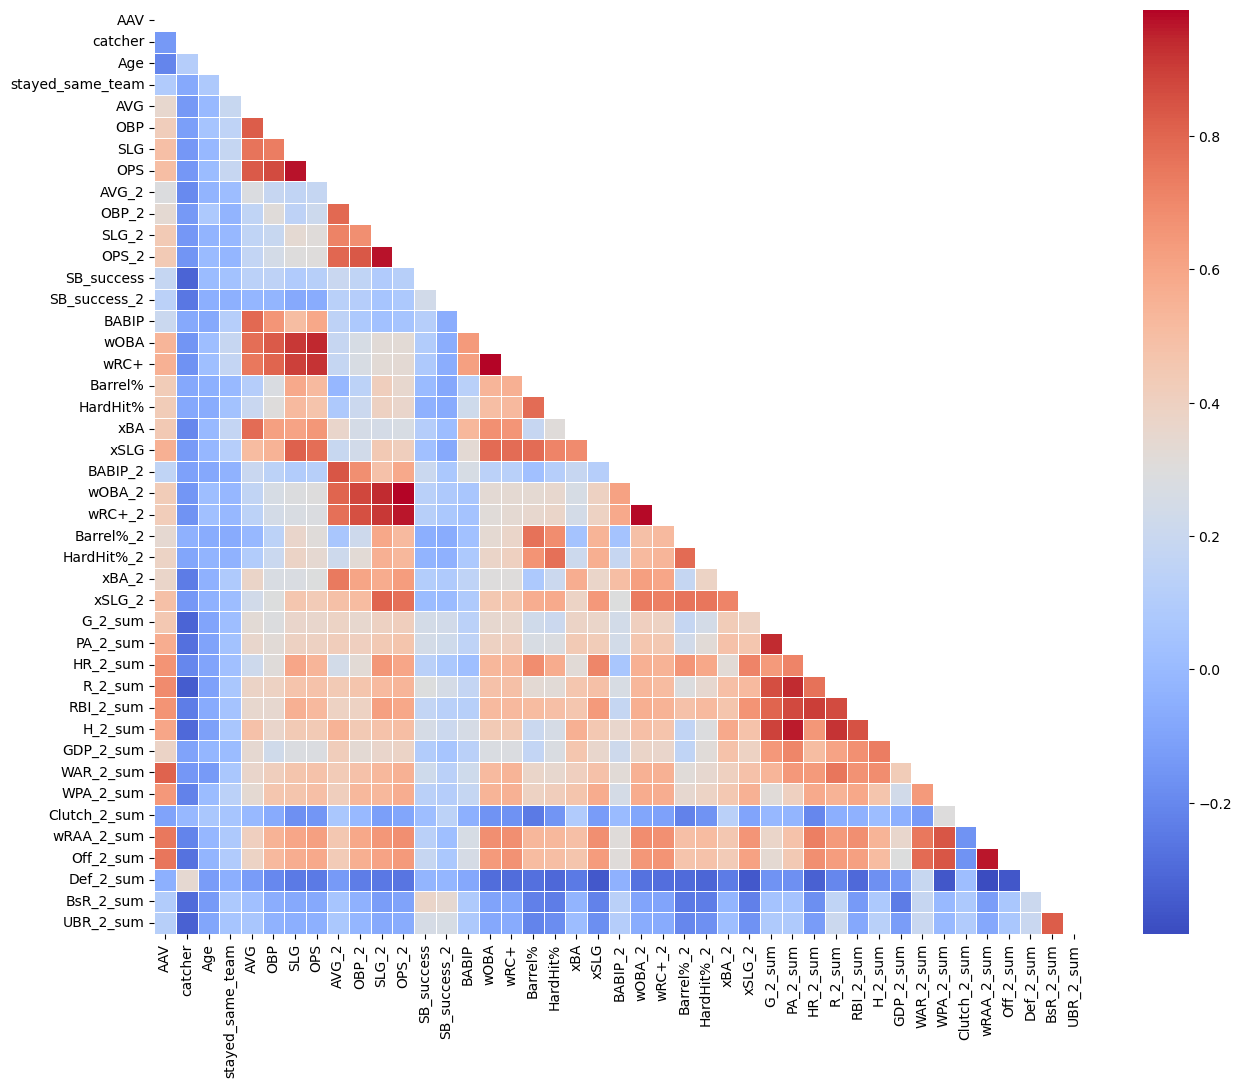

In [29]:
corr_matrix = df2.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(15, 12))


sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5, ax=ax)

plt.show()



In [30]:
df2.select_dtypes(include=['number']).corr().style.background_gradient("coolwarm", vmin=-1, vmax=1)

,AAV,Age,AVG,OBP,SLG,OPS,AVG_2,OBP_2,SLG_2,OPS_2,SB_success,SB_success_2,BABIP,wOBA,wRC+,Barrel%,HardHit%,xBA,xSLG,BABIP_2,wOBA_2,wRC+_2,Barrel%_2,HardHit%_2,xBA_2,xSLG_2,G_2_sum,PA_2_sum,HR_2_sum,R_2_sum,RBI_2_sum,H_2_sum,GDP_2_sum,WAR_2_sum,WPA_2_sum,Clutch_2_sum,wRAA_2_sum,Off_2_sum,Def_2_sum,BsR_2_sum,UBR_2_sum
AAV,1.000000,-0.210652,0.350959,0.416660,0.494135,0.499469,0.290532,0.335156,0.440770,0.439463,0.179116,0.137173,0.203326,0.537747,0.555383,0.431452,0.428749,0.446952,0.559170,0.160147,0.429441,0.421483,0.344733,0.388265,0.369707,0.489824,0.451914,0.570088,0.660979,0.690064,0.663410,0.597037,0.379227,0.807999,0.645415,-0.102513,0.747208,0.754166,-0.047937,0.097175,0.122979
Age,-0.210652,1.000000,-0.002500,0.047823,-0.011759,0.007997,-0.031703,0.075300,-0.033302,0.000326,0.006992,-0.051313,-0.073212,0.016852,0.021008,-0.044733,-0.063013,-0.005735,-0.016736,-0.080678,0.017393,0.027939,-0.063345,-0.029527,-0.039731,-0.043478,-0.094821,-0.098901,-0.096307,-0.107435,-0.070400,-0.110523,-0.021111,-0.131454,0.004889,0.065283,-0.012483,-0.026496,-0.130216,-0.132076,-0.089839
AVG,0.350959,-0.002500,1.000000,0.825766,0.757979,0.830329,0.283725,0.157273,0.157305,0.169406,0.139274,-0.020719,0.794430,0.775571,0.751554,0.110557,0.195902,0.781051,0.512606,0.197631,0.166601,0.143126,-0.008422,0.101005,0.377001,0.232102,0.328771,0.357344,0.217125,0.381017,0.355650,0.483588,0.342011,0.363643,0.337957,-0.002494,0.407389,0.386506,-0.130945,0.030910,0.062487
OBP,0.416660,0.047823,0.825766,1.000000,0.730538,0.870511,0.185159,0.308354,0.193504,0.246649,0.149527,-0.024320,0.655921,0.829479,0.805775,0.277608,0.302625,0.621243,0.550723,0.141133,0.263820,0.244778,0.144625,0.202404,0.274571,0.292170,0.286732,0.319336,0.311390,0.391024,0.348456,0.364257,0.226691,0.414511,0.460549,-0.070105,0.547046,0.519313,-0.201441,-0.058030,-0.038083
SLG,0.494135,-0.011759,0.757979,0.730538,1.000000,0.972016,0.163070,0.150288,0.338532,0.301841,0.093628,-0.073144,0.505699,0.911527,0.893440,0.586351,0.513890,0.608384,0.812601,0.100822,0.286921,0.272486,0.362874,0.381301,0.275915,0.464514,0.364176,0.398688,0.595481,0.474572,0.557533,0.438709,0.284868,0.465098,0.469707,-0.173189,0.596453,0.567820,-0.248702,-0.074312,-0.050876
OPS,0.499469,0.007997,0.830329,0.870511,0.972016,1.000000,0.181204,0.214371,0.310526,0.302365,0.118915,-0.061107,0.590050,0.942291,0.921105,0.518077,0.474420,0.652179,0.775108,0.121192,0.297520,0.280567,0.311242,0.344390,0.293272,0.435248,0.361115,0.397199,0.536286,0.476549,0.521691,0.441493,0.283307,0.477793,0.496944,-0.148928,0.618049,0.587871,-0.248537,-0.073527,-0.049758
AVG_2,0.290532,-0.031703,0.283725,0.185159,0.163070,0.181204,1.000000,0.794706,0.718463,0.799096,0.195460,0.123799,0.147607,0.187996,0.181052,-0.016305,0.082338,0.364678,0.193544,0.840938,0.802843,0.771265,0.061119,0.216715,0.743432,0.487592,0.385604,0.418301,0.242058,0.442536,0.393531,0.549260,0.419444,0.436243,0.410617,0.067935,0.455671,0.433566,-0.133918,0.055484,0.072716
OBP_2,0.335156,0.075300,0.157273,0.308354,0.150288,0.214371,0.794706,1.000000,0.677872,0.837284,0.156440,0.112000,0.078579,0.260373,0.265214,0.141063,0.205871,0.250253,0.234435,0.680306,0.880806,0.859187,0.220659,0.324610,0.601571,0.511772,0.353463,0.407963,0.325443,0.466480,0.391433,0.446102,0.331074,0.484984,0.528033,-0.004087,0.592057,0.564885,-0.235238,-0.040074,-0.021531
SLG_2,0.440770,-0.033302,0.157305,0.193504,0.338532,0.310526,0.718463,0.677872,1.000000,0.969544,0.092289,0.056342,0.032947,0.323107,0.327754,0.412563,0.396010,0.248522,0.448309,0.485614,0.936732,0.912954,0.592060,0.561932,0.578126,0.803919,0.394779,0.444402,0.653894,0.516840,0.617159,0.475806,0.364161,0.524685,0.527652,-0.118010,0.649797,0.607835,-0.253061,-0.120774,-0.075284
OPS_2,0.439463,0.000326,0.169406,0.246649,0.301841,0.302365,0.799096,0.837284,0.969544,1.000000,0.120761,0.079218,0.050684,0.327048,0.332121,0.353806,0.363070,0.268205,0.411501,0.587797,0.990098,0.965213,0.513821,0.526028,0.630372,0.768369,0.411358,0.4664

OBP and SLG are highly correlated with OPS, which makes sense as OPS is the result of adding both. We knew that from the traditional stats model, but in this one we will stay only with OPS. To OBP and SLG we can add AVG as a highly correlated variable to OPS. 

But wait, all 4 of them seem to be extremely correlated with our new advanced variables wOBA and wRC+. And these two have a higher correlation with our target variable. It is even higher when comparing it to the second season (OPS_2 v wOBA_2 and wRC+_2). It doesn't end there as wOBA and wRC+ are also almost perfectly correlated. wRC+ seems to have a higher correlation to AAV in the closest season, and wOBA in the second to last. To mix it up a little I'll choose wRC+ and wOBA_2.  

WPA_2_sum seems better suited when calculating AAV than Clutch_2_sum in terms of contextual At Bats. 

I realized GDP has more to do with playing time than with actual performance, as its more correlated to PAs than to AAV. 

The high correlation between wRAA and Off is not a surprise. Off has a higher correlation to AAV. 

The last 3 variables show us teams really don't pay for base running or defense. In reality teams are paying pitchers to make their best effort to stop the other team from scoring and pay batters to focus on offense and score as many runs they can. And for base running most teams get a super speedy guy that comes in from the bench to pinch run one inning and thats about it. 

Taking into account we didnt have a single variable that reached a correlation of 0.7 in the traditional stats model, we can start assuming this model will be better. 

In conclusion, the variables selected for this model, according to the previous analysis, eliminating those who are extremely similar to other statistics and trying to pick the one with better correlation with AAV, we have:


catcher, Age, wRC+, xSLG, wOBA_2, xSLG_2 HR_2_sum, R_2_sum, RBI_2_sum, WAR_2_sum, WPA_2_sum, Off_2_sum 

In [31]:
columns_to_keep = ['Name','AAV',
    'catcher', 'Age', 'WAR_2_sum', 'wRC+', 'xSLG', 'wOBA_2', 'xSLG_2',
    'HR_2_sum', 'R_2_sum', 'RBI_2_sum', 'WPA_2_sum', 'Off_2_sum'
]

model_df = df2[columns_to_keep]
model_df.head()

,Name,AAV,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum
0,Shohei Ohtani,35.122807,False,29,10.151636,179.583659,0.638,0.369625,0.549,78,192,190,6.240769,89.395896
1,Cody Bellinger,26.666667,False,28,5.780272,134.283843,0.434,0.284044,0.354,45,165,165,1.137959,18.272228
2,Teoscar Hernandez,23.500000,False,31,4.722464,104.705412,0.476,0.347753,0.501,51,141,170,-0.388117,17.941033
3,Matt Chapman,18.000000,False,31,6.931136,110.043286,0.457,0.330734,0.440,44,149,130,-1.107047,19.770645
4,Rhys Hoskins,17.000000,False,31,4.732510,122.328017,0.445,0.345172,0.445,30,81,79,2.942371,29.668726


In [32]:
model_df.select_dtypes(include=['number']).corr().style.background_gradient("coolwarm", vmin=-1, vmax=1)

,AAV,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum
AAV,1.000000,-0.210652,0.807999,0.555383,0.559170,0.429441,0.489824,0.660979,0.690064,0.663410,0.645415,0.754166
Age,-0.210652,1.000000,-0.131454,0.021008,-0.016736,0.017393,-0.043478,-0.096307,-0.107435,-0.070400,0.004889,-0.026496
WAR_2_sum,0.807999,-0.131454,1.000000,0.542645,0.484167,0.553291,0.480983,0.641926,0.756679,0.669303,0.642037,0.787548
wRC+,0.555383,0.021008,0.542645,1.000000,0.782048,0.337213,0.468325,0.539818,0.487644,0.519948,0.551945,0.669778
xSLG,0.559170,-0.016736,0.484167,0.782048,1.000000,0.396451,0.646696,0.703594,0.491681,0.641071,0.577676,0.636214
wOBA_2,0.429441,0.017393,0.553291,0.337213,0.396451,1.000000,0.739031,0.561645,0.531574,0.562668,0.573903,0.649217
xSLG_2,0.489824,-0.043478,0.480983,0.468325,0.646696,0.739031,1.000000,0.709231,0.514064,0.660701,0.553531,0.615441
HR_2_sum,0.660979,-0.096307,0.641926,0.539818,0.703594,0.561645,0.709231,1.000000,0.767035,0.901025,0.579281,0.677080
R_2_sum,0.690064,-0.107435,0.756679,0.487644,0.491681,0.531574,0.514064,0.767035,1.000000,0.868132,0.549257,0.627657
RBI_2_sum,0.663410,-0.070400,0.669303,0.519948,0.641071,0.562668,0.660701,0.901025,0.868132,1.000000,0.589684,0.620043


## DF TO CSV

In [33]:
model_df.to_csv('advmodel_df.csv', index=False)

In [34]:
target = "AAV"
features = [col for col in model_df.columns if col != target and col!= "Name"]
X, y = model_df[features], model_df[target]

## Train-Test Split

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (294, 12)
X_test shape: (126, 12)
y_train shape: (294,)
y_test shape: (126,)


### Distribution of y train values

C:\Users\mfran\AppData\Local\Temp\ipykernel_4720\3840007699.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_train, shade=True)


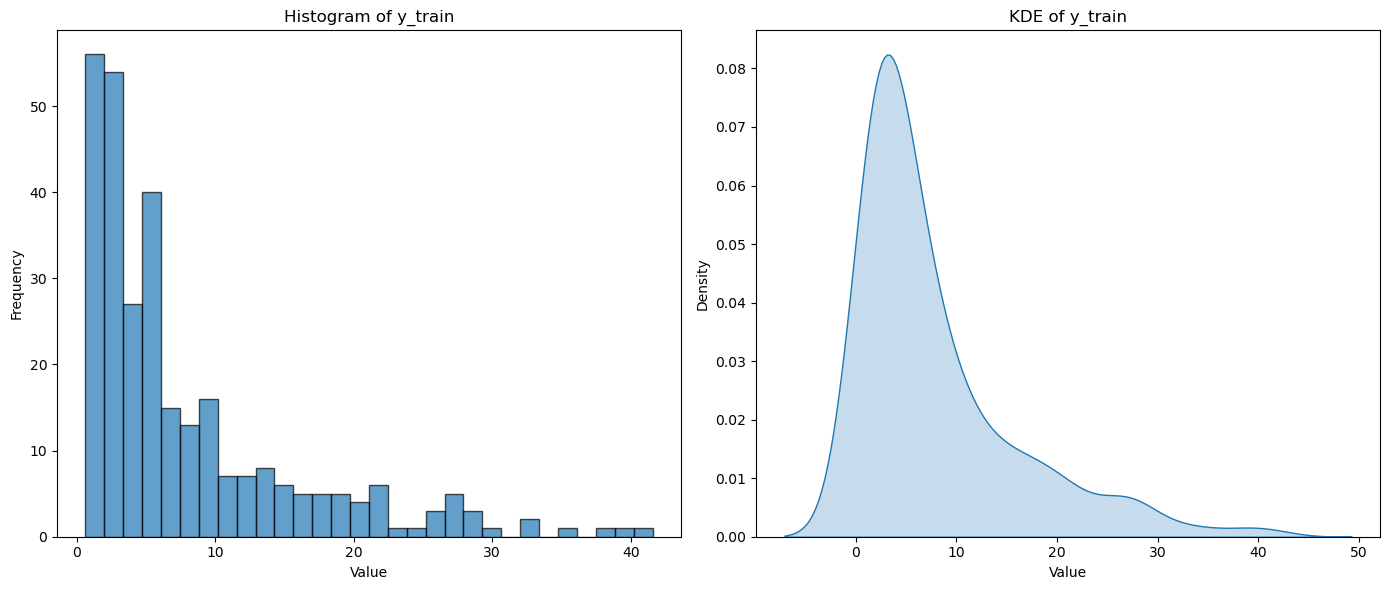

In [36]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of y_train')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(y_train, shade=True)
plt.title('KDE of y_train')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

### Distribution of test values 

C:\Users\mfran\AppData\Local\Temp\ipykernel_4720\893388450.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, shade=True)


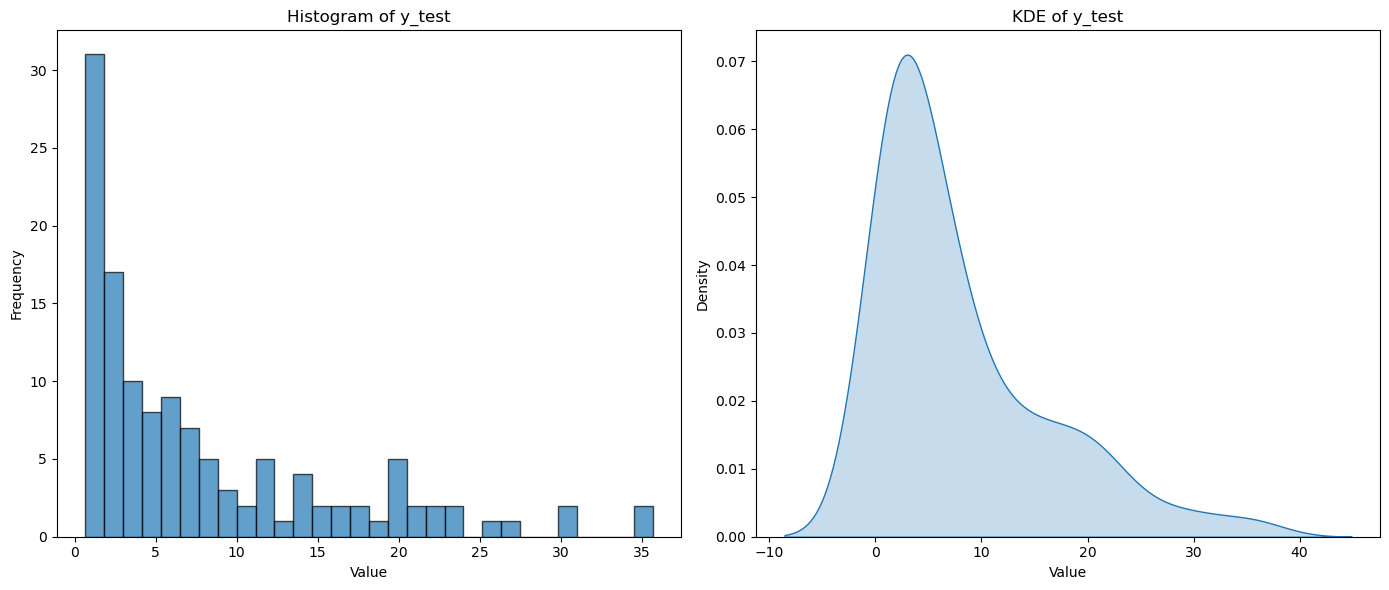

In [37]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(y_test, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of y_test')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(y_test, shade=True)
plt.title('KDE of y_test')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

## Linear Model

In [38]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [39]:
linear_model.coef_, linear_model.intercept_

(array([ 1.41678353e+00, -2.69245773e-01,  1.25404131e+00, -1.13485781e-02,
         6.26645043e+00, -4.99402114e+01,  4.70459356e+00, -2.66570525e-02,
         2.07074955e-02,  2.81906274e-02,  1.88116781e-01,  1.40338215e-01]),
 20.66239904614038)

In [40]:
linear_y_pred = linear_model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum,y_real,y_pred,err,%_err
378,False,32,1.690518,109.537260,0.360,0.302992,0.360,25,93,80,-0.445498,2.992722,8.003433,5.592310,2.411124,30.126117
165,False,28,-0.936736,-60.467239,0.132,0.278556,0.363,7,32,32,-0.625584,-14.675757,1.535986,0.459712,1.076273,70.070538
17,False,32,2.762809,92.328774,0.366,0.346548,0.438,49,122,132,-1.572710,5.732043,6.500000,6.960724,-0.460724,-7.088059
179,False,33,3.576538,115.407509,0.517,0.336945,0.493,55,153,201,3.140679,19.063207,19.793828,14.319259,5.474569,27.657960
4,False,31,4.732510,122.328017,0.445,0.345172,0.445,30,81,79,2.942371,29.668726,17.000000,12.328269,4.671731,27.480769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,False,29,2.923784,94.205417,0.380,0.292239,0.380,13,127,95,-0.266994,-9.974988,6.156487,8.537573,-2.381086,-38.676055
223,False,31,0.814956,93.780657,0.385,0.267546,0.344,15,68,64,0.500577,-12.994359,1.187630,4.026159,-2.838529,-239.007951
368,False,35,7.700740,122.392308,0.382,0.333058,0.382,23,159,108,2.464556,27.342872,17.238164,17.089679,0.148484,0.861370
274,False,32,6.258826,114.671067,0.463,0.369820,0.515,57,179,166,3.212834,36.418405,23.666191,18.031464,5.634727,23.809185


### Evaluation Metrics

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 4.359340474283007
MAPE: 0.8668759874411834
R^2: 0.708383653340561


From the start we have a better model than the one we had with the traditional stats. 

The RMSE behaved in a similar way as we are failing by 4.73 on average (we had 4.99 in comparison). The MAPE in this case is significantly lower, 106% on average to 78%. Finally the R^2 score saw the biggest improvement, from 0.60 to 0.70.

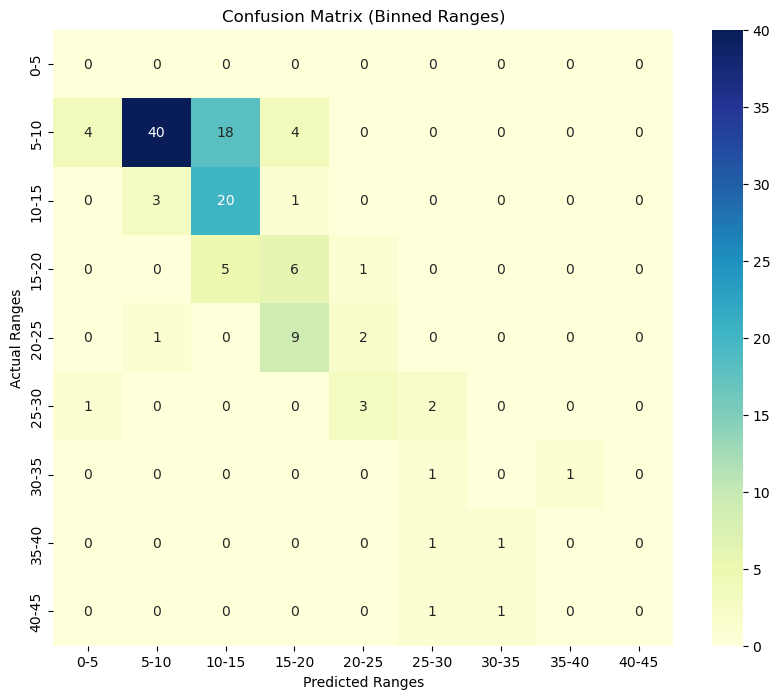

In [42]:
def bin_values(values, bin_size):
    return np.floor(values / bin_size).astype(int)

bin_size = 5
y_test_binned = bin_values(y_test, bin_size)
linear_y_pred_binned = bin_values(linear_y_pred, bin_size)

conf_matrix = confusion_matrix(y_test_binned, linear_y_pred_binned)

bins = range(conf_matrix.shape[0])
bin_labels = [f'{i*bin_size}-{(i+1)*bin_size}' for i in bins]
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels, columns=bin_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix (Binned Ranges)')
plt.xlabel('Predicted Ranges')
plt.ylabel('Actual Ranges')
plt.show()

#### Correction for negative predictions (Linear Regression)

In [43]:
negative_values_exist = (results_df["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


In [44]:
linear_model = LinearRegression()

y_train_log = np.log(y_train)
linear_model.fit(X_train, y_train_log)

linear_y_pred_log = linear_model.predict(X_test)


linear_y_pred = np.exp(linear_y_pred_log)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum,y_real,y_pred,err,%_err
378,False,32,1.690518,109.537260,0.360,0.302992,0.360,25,93,80,-0.445498,2.992722,8.003433,3.450846,4.552587,56.882926
165,False,28,-0.936736,-60.467239,0.132,0.278556,0.363,7,32,32,-0.625584,-14.675757,1.535986,0.629519,0.906466,59.015280
17,False,32,2.762809,92.328774,0.366,0.346548,0.438,49,122,132,-1.572710,5.732043,6.500000,4.741668,1.758332,27.051254
179,False,33,3.576538,115.407509,0.517,0.336945,0.493,55,153,201,3.140679,19.063207,19.793828,11.416721,8.377107,42.321814
4,False,31,4.732510,122.328017,0.445,0.345172,0.445,30,81,79,2.942371,29.668726,17.000000,6.142749,10.857251,63.866185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,False,29,2.923784,94.205417,0.380,0.292239,0.380,13,127,95,-0.266994,-9.974988,6.156487,5.651722,0.504765,8.198908
223,False,31,0.814956,93.780657,0.385,0.267546,0.344,15,68,64,0.500577,-12.994359,1.187630,2.773944,-1.586314,-133.569751
368,False,35,7.700740,122.392308,0.382,0.333058,0.382,23,159,108,2.464556,27.342872,17.238164,13.281146,3.957018,22.954984
274,False,32,6.258826,114.671067,0.463,0.369820,0.515,57,179,166,3.212834,36.418405,23.666191,15.674373,7.991817,33.768922


In [45]:
print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 5.381011827653903
MAPE: 0.5452623235901788
R^2: 0.5556776302163127


In [46]:
negative_values_exist = (results_df["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are no negative values in the 'y_pred' column.


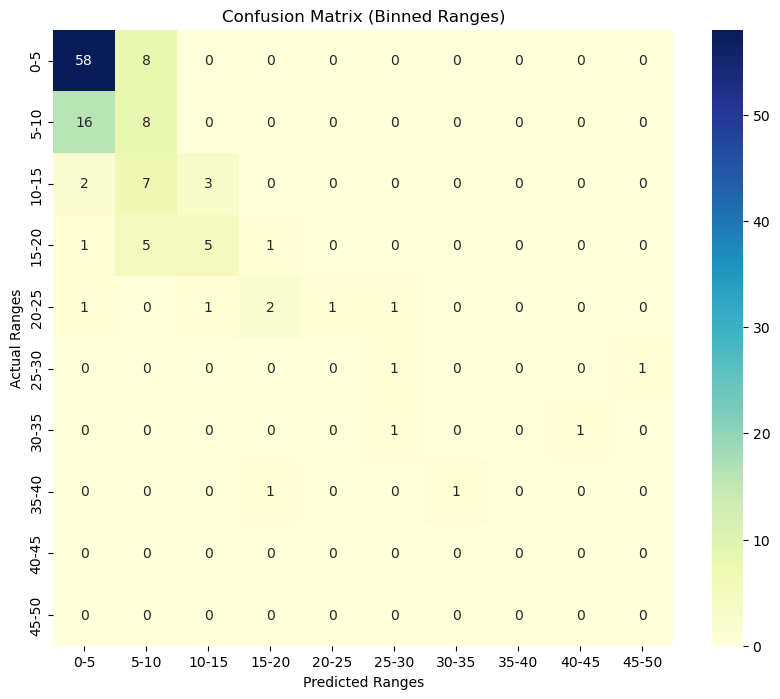

In [47]:
def bin_values(values, bin_size):
    return np.floor(values / bin_size).astype(int)

bin_size = 5
y_test_binned = bin_values(y_test, bin_size)
linear_y_pred_binned = bin_values(linear_y_pred, bin_size)

conf_matrix = confusion_matrix(y_test_binned, linear_y_pred_binned)

bins = range(conf_matrix.shape[0])
bin_labels = [f'{i*bin_size}-{(i+1)*bin_size}' for i in bins]
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels, columns=bin_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix (Binned Ranges)')
plt.xlabel('Predicted Ranges')
plt.ylabel('Actual Ranges')
plt.show()

### XGBoost Model

In [48]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

results_df_xgb = X_test.copy()
results_df_xgb["y_real"] = y_test
results_df_xgb["y_pred"] = xgb_y_pred
results_df_xgb["err"] = results_df_xgb["y_real"] - results_df_xgb["y_pred"]
results_df_xgb["%_err"] = results_df_xgb["err"] / results_df_xgb["y_real"] * 100


results_df_xgb

,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum,y_real,y_pred,err,%_err
378,False,32,1.690518,109.537260,0.360,0.302992,0.360,25,93,80,-0.445498,2.992722,8.003433,3.466866,4.536567,56.682764
165,False,28,-0.936736,-60.467239,0.132,0.278556,0.363,7,32,32,-0.625584,-14.675757,1.535986,1.171530,0.364455,23.727788
17,False,32,2.762809,92.328774,0.366,0.346548,0.438,49,122,132,-1.572710,5.732043,6.500000,4.848818,1.651182,25.402803
179,False,33,3.576538,115.407509,0.517,0.336945,0.493,55,153,201,3.140679,19.063207,19.793828,17.600784,2.193044,11.079432
4,False,31,4.732510,122.328017,0.445,0.345172,0.445,30,81,79,2.942371,29.668726,17.000000,10.315336,6.684664,39.321552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,False,29,2.923784,94.205417,0.380,0.292239,0.380,13,127,95,-0.266994,-9.974988,6.156487,4.450452,1.706035,27.711180
223,False,31,0.814956,93.780657,0.385,0.267546,0.344,15,68,64,0.500577,-12.994359,1.187630,2.524395,-1.336765,-112.557379
368,False,35,7.700740,122.392308,0.382,0.333058,0.382,23,159,108,2.464556,27.342872,17.238164,13.750659,3.487505,20.231301
274,False,32,6.258826,114.671067,0.463,0.369820,0.515,57,179,166,3.212834,36.418405,23.666191,19.673851,3.992340,16.869380


In [49]:
print(f"RMSE: {mean_squared_error(y_test, xgb_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, xgb_y_pred)}")
print(f"R^2: {r2_score(y_test, xgb_y_pred)}")

RMSE: 4.190024782136014
MAPE: 0.6692863236629057
R^2: 0.730596354185217


The XGBoost model performed better in every aspect. In terms of RMSE we have 4.68, similar to the linear model, but significantly better than XGBoost model with traditional stats (5.73). The average deviation (MAPE) saw a big decrease (0,61 compared to 0,78 and 0,87 respectively. And R^2 score increase slightly to .706.

#### Testing 0-5 range values

In [50]:
range_min, range_max = 0, 5

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df_xgb['y_real_in_range'] = results_df_xgb['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df_xgb['in_range'] = results_df_xgb.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df_xgb['y_real_in_range'].sum()

correct_predictions = results_df_xgb['in_range'].sum()

print(f'Number of Real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of Real values in the range 0-5: 66
Number of correct predictions in the range 0-5: 53


#### All ranges visualized with a bar plot

   Range  Total Real in Range  Correct_Predictions
0    0-5                   66                   53
1   5-10                   24                   13
2  10-15                   13                    2
3  15-20                   12                    2
4  20-25                    6                    1
5  25-30                    2                    1
6  30-35                    2                    1
7  35-40                    2                    0
8    40+                    0                    0


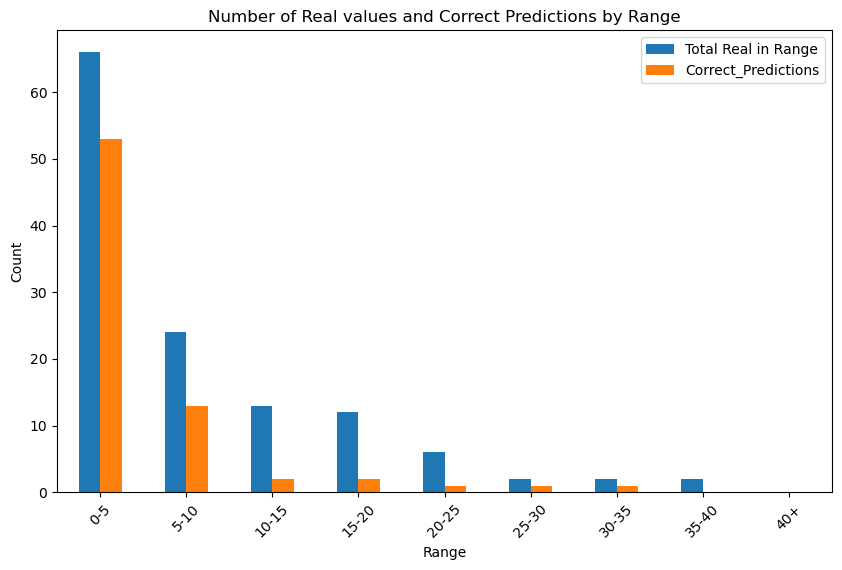

In [51]:
ranges = [(0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, float('inf'))]

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_list = []

for range_min, range_max in ranges:
    results_df_xgb['y_real_in_range'] = results_df_xgb['y_real'].apply(lambda y: range_min <= y <= range_max)
    results_df_xgb['in_range'] = results_df_xgb.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df_xgb['y_real_in_range'].sum()
    
    correct_predictions = results_df_xgb['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total Real in Range': total_y_real_in_range,
        'Correct_Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of Real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Confusion Matrix 

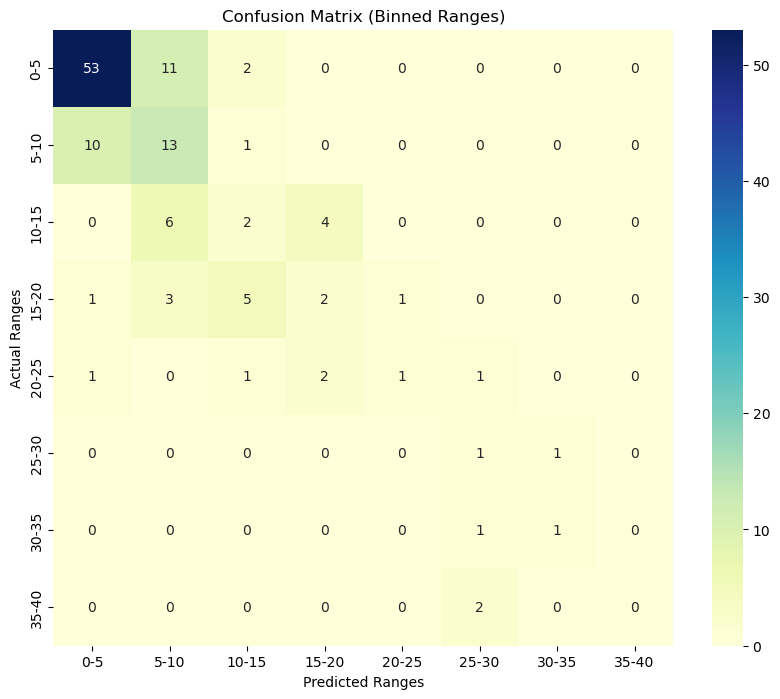

In [52]:
def bin_values(values, bin_size):
    return np.floor(values / bin_size).astype(int)

bin_size = 5
y_test_binned = bin_values(y_test, bin_size)
xgb_y_pred_binned = bin_values(xgb_y_pred, bin_size)

conf_matrix = confusion_matrix(y_test_binned, xgb_y_pred_binned)

bins = range(conf_matrix.shape[0])
bin_labels = [f'{i*bin_size}-{(i+1)*bin_size}' for i in bins]
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels, columns=bin_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix (Binned Ranges)')
plt.xlabel('Predicted Ranges')
plt.ylabel('Actual Ranges')
plt.show()

#### Correction for negative predictions (XGBoost Regression)

In [53]:
negative_values_exist = (results_df_xgb["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are no negative values in the 'y_pred' column.


## Ridge Regression

In [54]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()

ridge_model.fit(X_train, y_train)

ridge_y_pred = ridge_model.predict(X_test)

results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge

,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum,y_real,y_pred,err,%_err
378,False,32,1.690518,109.537260,0.360,0.302992,0.360,25,93,80,-0.445498,2.992722,8.003433,5.867356,2.136077,26.689513
165,False,28,-0.936736,-60.467239,0.132,0.278556,0.363,7,32,32,-0.625584,-14.675757,1.535986,-2.910467,4.446452,289.485306
17,False,32,2.762809,92.328774,0.366,0.346548,0.438,49,122,132,-1.572710,5.732043,6.500000,7.882999,-1.382999,-21.276900
179,False,33,3.576538,115.407509,0.517,0.336945,0.493,55,153,201,3.140679,19.063207,19.793828,13.408152,6.385676,32.260944
4,False,31,4.732510,122.328017,0.445,0.345172,0.445,30,81,79,2.942371,29.668726,17.000000,12.735651,4.264349,25.084409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,False,29,2.923784,94.205417,0.380,0.292239,0.380,13,127,95,-0.266994,-9.974988,6.156487,8.037712,-1.881225,-30.556797
223,False,31,0.814956,93.780657,0.385,0.267546,0.344,15,68,64,0.500577,-12.994359,1.187630,3.366056,-2.178426,-183.426361
368,False,35,7.700740,122.392308,0.382,0.333058,0.382,23,159,108,2.464556,27.342872,17.238164,16.785759,0.452405,2.624436
274,False,32,6.258826,114.671067,0.463,0.369820,0.515,57,179,166,3.212834,36.418405,23.666191,17.726431,5.939760,25.098083


In [55]:
print(f"RMSE: {mean_squared_error(y_test, ridge_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, ridge_y_pred)}")
print(f"R^2: {r2_score(y_test, ridge_y_pred)}")

RMSE: 4.429162026739255
MAPE: 0.8807379794996856
R^2: 0.6989674751804089


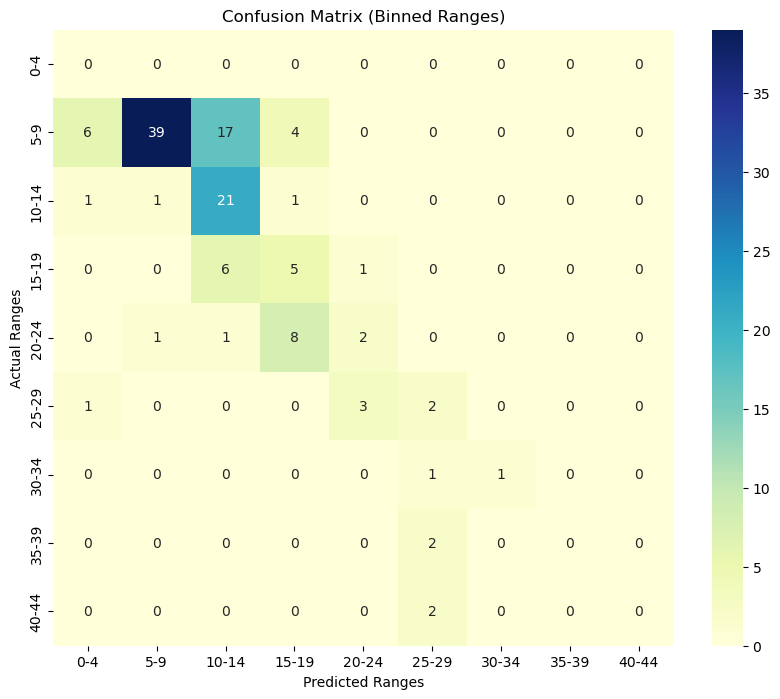

In [56]:
def bin_values(values, bin_size):
    return np.floor(values / bin_size).astype(int)

bin_size = 5
y_test_binned = bin_values(y_test, bin_size)
ridge_y_pred_binned = bin_values(ridge_y_pred, bin_size)

conf_matrix = confusion_matrix(y_test_binned, ridge_y_pred_binned)

bins = range(conf_matrix.shape[0])
bin_labels = [f'{i*bin_size}-{(i+1)*bin_size-1}' for i in bins]
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels, columns=bin_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix (Binned Ranges)')
plt.xlabel('Predicted Ranges')
plt.ylabel('Actual Ranges')
plt.show()

#### Correction for negative predictions

In [57]:
negative_values_exist = (results_df_ridge["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


In [58]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


y_train_log = np.log(y_train)


ridge_model = Ridge()
ridge_model.fit(X_train, y_train_log)


ridge_y_pred_log = ridge_model.predict(X_test)


ridge_y_pred = np.exp(ridge_y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test, ridge_y_pred))
r2 = r2_score(y_test, ridge_y_pred)
mape = np.mean(np.abs((y_test - ridge_y_pred) / y_test)) 

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R^2: {r2}")


results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge

RMSE: 5.383324994110076
MAPE: 0.5536088609714472
R^2: 0.5552955412911156


,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum,y_real,y_pred,err,%_err
378,False,32,1.690518,109.537260,0.360,0.302992,0.360,25,93,80,-0.445498,2.992722,8.003433,3.696616,4.306817,53.812119
165,False,28,-0.936736,-60.467239,0.132,0.278556,0.363,7,32,32,-0.625584,-14.675757,1.535986,0.603016,0.932970,60.740797
17,False,32,2.762809,92.328774,0.366,0.346548,0.438,49,122,132,-1.572710,5.732043,6.500000,5.233242,1.266758,19.488589
179,False,33,3.576538,115.407509,0.517,0.336945,0.493,55,153,201,3.140679,19.063207,19.793828,10.887789,8.906039,44.994019
4,False,31,4.732510,122.328017,0.445,0.345172,0.445,30,81,79,2.942371,29.668726,17.000000,6.238686,10.761314,63.301850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,False,29,2.923784,94.205417,0.380,0.292239,0.380,13,127,95,-0.266994,-9.974988,6.156487,5.452552,0.703935,11.434033
223,False,31,0.814956,93.780657,0.385,0.267546,0.344,15,68,64,0.500577,-12.994359,1.187630,2.730062,-1.542432,-129.874827
368,False,35,7.700740,122.392308,0.382,0.333058,0.382,23,159,108,2.464556,27.342872,17.238164,13.391307,3.846856,22.315929
274,False,32,6.258826,114.671067,0.463,0.369820,0.515,57,179,166,3.212834,36.418405,23.666191,15.595174,8.071017,34.103573


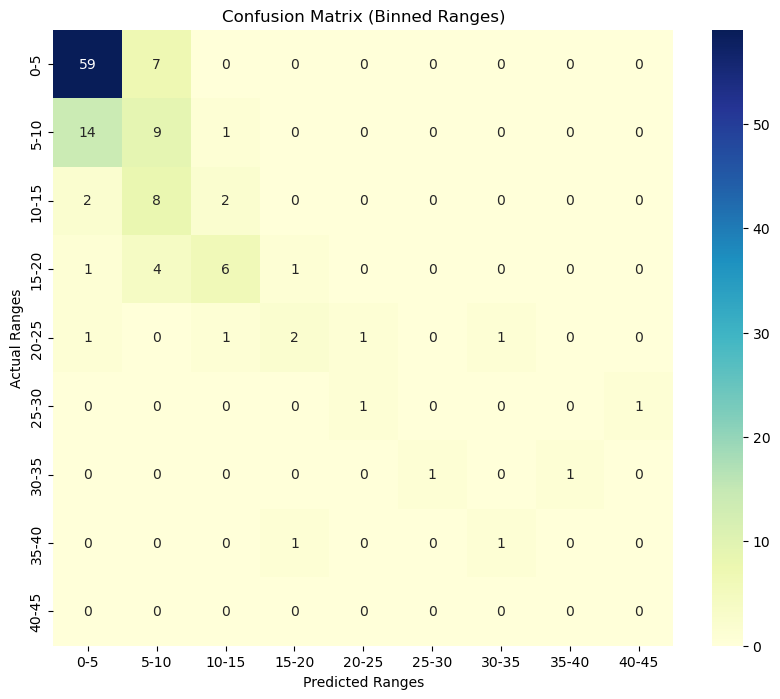

In [59]:
def bin_values(values, bin_size):
    return np.floor(values / bin_size).astype(int)

bin_size = 5
y_test_binned = bin_values(y_test, bin_size)
ridge_y_pred_binned = bin_values(ridge_y_pred, bin_size)

conf_matrix = confusion_matrix(y_test_binned, ridge_y_pred_binned)

bins = range(conf_matrix.shape[0])
bin_labels = [f'{i*bin_size}-{(i+1)*bin_size}' for i in bins]
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels, columns=bin_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix (Binned Ranges)')
plt.xlabel('Predicted Ranges')
plt.ylabel('Actual Ranges')
plt.show()

### Min Max Scaling

In [60]:
y_train_log = np.log(y_train)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train_log)

ridge_y_pred_log = ridge_model.predict(X_test_scaled)

ridge_y_pred = np.exp(ridge_y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test, ridge_y_pred))
r2 = r2_score(y_test, ridge_y_pred)
mape = np.mean(np.abs((y_test - ridge_y_pred) / y_test))

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R^2: {r2}")

results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge

RMSE: 5.168477348809252
MAPE: 0.5484396370339518
R^2: 0.5900833866657235


,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum,y_real,y_pred,err,%_err
378,False,32,1.690518,109.537260,0.360,0.302992,0.360,25,93,80,-0.445498,2.992722,8.003433,3.649070,4.354363,54.406187
165,False,28,-0.936736,-60.467239,0.132,0.278556,0.363,7,32,32,-0.625584,-14.675757,1.535986,0.754562,0.781423,50.874383
17,False,32,2.762809,92.328774,0.366,0.346548,0.438,49,122,132,-1.572710,5.732043,6.500000,5.214528,1.285472,19.776499
179,False,33,3.576538,115.407509,0.517,0.336945,0.493,55,153,201,3.140679,19.063207,19.793828,11.943221,7.850607,39.661894
4,False,31,4.732510,122.328017,0.445,0.345172,0.445,30,81,79,2.942371,29.668726,17.000000,6.050247,10.949753,64.410311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,False,29,2.923784,94.205417,0.380,0.292239,0.380,13,127,95,-0.266994,-9.974988,6.156487,5.267810,0.888677,14.434814
223,False,31,0.814956,93.780657,0.385,0.267546,0.344,15,68,64,0.500577,-12.994359,1.187630,2.763886,-1.576256,-132.722864
368,False,35,7.700740,122.392308,0.382,0.333058,0.382,23,159,108,2.464556,27.342872,17.238164,11.538102,5.700062,33.066528
274,False,32,6.258826,114.671067,0.463,0.369820,0.515,57,179,166,3.212834,36.418405,23.666191,15.858922,7.807269,32.989123


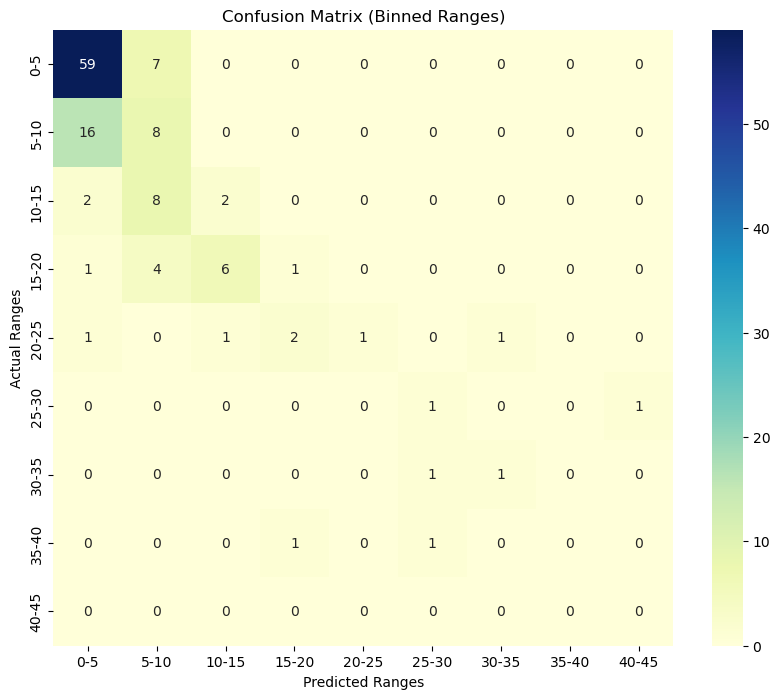

In [61]:
def bin_values(values, bin_size):
    return np.floor(values / bin_size).astype(int)

bin_size = 5
y_test_binned = bin_values(y_test, bin_size)
ridge_y_pred_binned = bin_values(ridge_y_pred, bin_size)

conf_matrix = confusion_matrix(y_test_binned, ridge_y_pred_binned)

bins = range(conf_matrix.shape[0])
bin_labels = [f'{i*bin_size}-{(i+1)*bin_size}' for i in bins]
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels, columns=bin_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix (Binned Ranges)')
plt.xlabel('Predicted Ranges')
plt.ylabel('Actual Ranges')
plt.show()

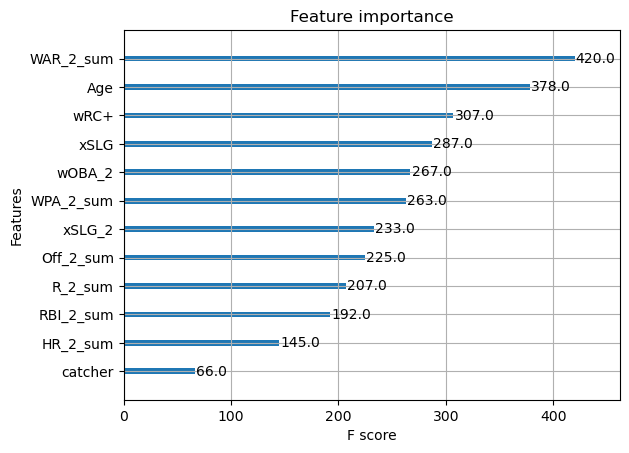

In [62]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(xgb_model)
plt.show()


### TESTING BEST MODEL: 

#### XGBOOST BEST 5 PREDICTIONS

In [63]:
results_df_xgb['absolute_difference'] = abs(results_df_xgb['y_real'] - results_df_xgb['y_pred'])

sorted_df = results_df_xgb.sort_values(by='absolute_difference')

closest_5_predictions = sorted_df.head(5)

closest_5_predictions

,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum,y_real,y_pred,err,%_err,y_real_in_range,in_range,absolute_difference
415,False,31,0.281237,22.576701,0.293,0.275466,0.293,1,64,22,-0.116954,-9.811410,1.231297,1.202114,0.029184,2.370155,False,False,0.029184
350,False,34,0.443074,78.592108,0.318,0.269233,0.305,5,87,68,-1.263598,-27.594899,2.342204,2.266892,0.075313,3.215454,False,False,0.075313
341,False,34,1.109366,123.056065,0.480,0.283982,0.317,25,67,65,-1.811588,-10.361885,4.098857,4.215956,-0.117099,-2.856865,False,False,0.117099
159,False,33,1.041091,81.492161,0.321,0.305601,0.396,10,37,42,-2.491223,-6.800546,1.919982,2.039487,-0.119505,-6.224290,False,False,0.119505
329,False,30,2.355889,118.536493,0.404,0.242199,0.284,24,72,60,-1.644674,9.469413,10.539919,10.668959,-0.129040,-1.224294,False,False,0.129040


In [64]:
results_df_xgb_with_names = results_df_xgb.merge(model_df[['Name']], left_index=True, right_index=True)

results_df_xgb_with_names['absolute_difference'] = abs(results_df_xgb_with_names['y_real'] - results_df_xgb_with_names['y_pred'])

sorted_df = results_df_xgb_with_names.sort_values(by='absolute_difference')

closest_5_predictions = sorted_df.head(5)

closest_5_predictions


,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum,y_real,y_pred,err,%_err,y_real_in_range,in_range,absolute_difference,Name
415,False,31,0.281237,22.576701,0.293,0.275466,0.293,1,64,22,-0.116954,-9.811410,1.231297,1.202114,0.029184,2.370155,False,False,0.029184,Eric Young Jr.
350,False,34,0.443074,78.592108,0.318,0.269233,0.305,5,87,68,-1.263598,-27.594899,2.342204,2.266892,0.075313,3.215454,False,False,0.075313,Michael Bourn
341,False,34,1.109366,123.056065,0.480,0.283982,0.317,25,67,65,-1.811588,-10.361885,4.098857,4.215956,-0.117099,-2.856865,False,False,0.117099,Stephen Drew
159,False,33,1.041091,81.492161,0.321,0.305601,0.396,10,37,42,-2.491223,-6.800546,1.919982,2.039487,-0.119505,-6.224290,False,False,0.119505,Charlie Culberson
329,False,30,2.355889,118.536493,0.404,0.242199,0.284,24,72,60,-1.644674,9.469413,10.539919,10.668959,-0.129040,-1.224294,False,False,0.129040,Michael Saunders


#### XGBOOST WORST 5 PREDICTIONS

In [65]:
sorted_df_desc = results_df_xgb_with_names.sort_values(by='absolute_difference', ascending=False)
furthest_5_predictions = sorted_df_desc.head(5)
furthest_5_predictions

,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum,y_real,y_pred,err,%_err,y_real_in_range,in_range,absolute_difference,Name
58,False,33,-0.292311,61.137524,0.322,0.274550,0.367,9,50,40,-3.065979,-19.673221,21.873111,1.996024,19.877087,90.874530,False,False,19.877087,Jason Heyward
367,True,30,0.932937,101.759923,0.412,0.364640,0.412,13,37,43,1.896050,1.902911,19.454499,4.193693,15.260806,78.443582,False,False,15.260806,Matt Wieters
61,False,31,2.701094,145.776975,0.502,0.315315,0.441,41,112,131,3.426924,19.325094,19.536665,5.612237,13.924428,71.273309,False,False,13.924428,Joc Pederson
366,False,29,4.368362,118.261032,0.414,0.321444,0.414,43,112,101,0.716082,20.016460,19.454499,8.383081,11.071418,56.909292,False,False,11.071418,Colby Rasmus
232,False,30,9.179445,124.768896,0.438,0.324884,0.380,46,115,126,-1.767315,8.937195,21.694382,12.399770,9.294612,42.843407,False,False,9.294612,Yasmani Grandal


#### 5 Players the model expected to receive less money

In [66]:
exp_less = results_df_xgb_with_names.sort_values(by='err', ascending=False)

exp_less.head(5)



,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum,y_real,y_pred,err,%_err,y_real_in_range,in_range,absolute_difference,Name
58,False,33,-0.292311,61.137524,0.322,0.274550,0.367,9,50,40,-3.065979,-19.673221,21.873111,1.996024,19.877087,90.874530,False,False,19.877087,Jason Heyward
367,True,30,0.932937,101.759923,0.412,0.364640,0.412,13,37,43,1.896050,1.902911,19.454499,4.193693,15.260806,78.443582,False,False,15.260806,Matt Wieters
61,False,31,2.701094,145.776975,0.502,0.315315,0.441,41,112,131,3.426924,19.325094,19.536665,5.612237,13.924428,71.273309,False,False,13.924428,Joc Pederson
366,False,29,4.368362,118.261032,0.414,0.321444,0.414,43,112,101,0.716082,20.016460,19.454499,8.383081,11.071418,56.909292,False,False,11.071418,Colby Rasmus
232,False,30,9.179445,124.768896,0.438,0.324884,0.380,46,115,126,-1.767315,8.937195,21.694382,12.399770,9.294612,42.843407,False,False,9.294612,Yasmani Grandal


#### 5 Players the model expected to receive more money

In [67]:
exp_more = results_df_xgb_with_names.sort_values(by='err', ascending=True)

exp_more.head(5)

,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum,y_real,y_pred,err,%_err,y_real_in_range,in_range,absolute_difference,Name
416,False,38,3.659902,99.739228,0.435,0.329665,0.435,48,129,158,1.413116,5.225017,1.231297,9.257774,-8.026477,-651.871505,False,False,8.026477,Marlon Byrd
403,False,33,4.563746,167.413302,0.562,0.409689,0.562,30,54,70,1.661604,29.330895,1.846946,9.825017,-7.978071,-431.960132,False,False,7.978071,Franklin Gutierrez
320,False,34,8.097747,136.187231,0.536,0.391518,0.517,81,193,238,4.895639,63.101996,23.422042,29.790287,-6.368245,-27.189110,False,False,6.368245,Edwin Encarnacion
291,False,31,3.975048,111.728577,0.356,0.323566,0.390,28,133,125,-0.656356,12.024710,4.733238,11.079441,-6.346203,-134.077405,False,False,6.346203,Eduardo NuÃ±ez
257,False,33,4.615422,110.580821,0.433,0.338038,0.430,37,134,134,1.592003,6.851070,4.160566,10.226587,-6.066021,-145.797955,False,False,6.066021,Asdrubal Cabrera


### Model with K-Fold Cross Validation

In [68]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

target = "AAV"
features = [col for col in model_df.columns if col != target and col != "Name"]
X, y = model_df[features], model_df[target]


kf = KFold(n_splits=5, shuffle=True, random_state=1)

xgb_model = XGBRegressor()

rmse_scores = []
mape_scores = []
r2_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred)**0.5
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    r2_scores.append(r2)


print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average MAPE: {np.mean(mape_scores)}")
print(f"Average R^2: {np.mean(r2_scores)}")

y_pred_all = cross_val_predict(xgb_model, X, y, cv=kf)

results_df_xgb = pd.DataFrame(X)
results_df_xgb["y_real"] = y
results_df_xgb["y_pred"] = y_pred_all
results_df_xgb["err"] = results_df_xgb["y_real"] - results_df_xgb["y_pred"]
results_df_xgb["%_err"] = results_df_xgb["err"] / results_df_xgb["y_real"] * 100


print(results_df_xgb)

overall_rmse = mean_squared_error(y, y_pred_all)**0.5
overall_mape = mean_absolute_percentage_error(y, y_pred_all)
overall_r2 = r2_score(y, y_pred_all)

print(f"Overall RMSE: {overall_rmse}")
print(f"Overall MAPE: {overall_mape}")
print(f"Overall R^2: {overall_r2}")


Average RMSE: 4.168618088038588
Average MAPE: 0.7126189587348214
Average R^2: 0.7111727559643117
     catcher  Age  WAR_2_sum        wRC+   xSLG    wOBA_2  xSLG_2  HR_2_sum  \
0      False   29  10.151636  179.583659  0.638  0.369625   0.549        78   
1      False   28   5.780272  134.283843  0.434  0.284044   0.354        45   
2      False   31   4.722464  104.705412  0.476  0.347753   0.501        51   
3      False   31   6.931136  110.043286  0.457  0.330734   0.440        44   
4      False   31   4.732510  122.328017  0.445  0.345172   0.445        30   
..       ...  ...        ...         ...    ...       ...     ...       ...   
415    False   31   0.281237   22.576701  0.293  0.275466   0.293         1   
416    False   38   3.659902   99.739228  0.435  0.329665   0.435        48   
417    False   35   0.195955   67.346766  0.285  0.301940   0.285         3   
418    False   32   0.334841   73.650239  0.335  0.308028   0.335         4   
419    False   30  -1.426632   82.

In [69]:
from sklearn.model_selection import KFold, cross_val_score

target = "AAV"
features = [col for col in model_df.columns if col != target and col != "Name"]
X, y = model_df[features], model_df[target]

kf = KFold(n_splits=5, shuffle=True, random_state=1)

xgb_model = XGBRegressor(random_state=1)


scores = cross_val_score(xgb_model, X, y, cv=kf)

print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {np.mean(scores)}")
print(f"Standard deviation of cross-validation scores: {np.std(scores)}")


Cross-validation scores: [0.70693644 0.67340663 0.79954802 0.76807313 0.60789957]
Mean cross-validation score: 0.7111727559643117
Standard deviation of cross-validation scores: 0.06805500405268018


### Model with observations without AAV > 20 using XGBoost

In [70]:
model_df.shape[0]

420

In [71]:
count = model_df[model_df['AAV'] > 20].shape[0]

print(f"Number of observations with 'AAV' greater than 20: {count}")

Number of observations with 'AAV' greater than 20: 40


In [72]:
df_filtered = model_df[model_df['AAV'] <= 20]

In [73]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 3 to 419
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       380 non-null    object 
 1   AAV        380 non-null    float64
 2   catcher    380 non-null    bool   
 3   Age        380 non-null    int64  
 4   WAR_2_sum  380 non-null    float64
 5   wRC+       380 non-null    float64
 6   xSLG       380 non-null    float64
 7   wOBA_2     380 non-null    float64
 8   xSLG_2     380 non-null    float64
 9   HR_2_sum   380 non-null    int64  
 10  R_2_sum    380 non-null    int64  
 11  RBI_2_sum  380 non-null    int64  
 12  WPA_2_sum  380 non-null    float64
 13  Off_2_sum  380 non-null    float64
dtypes: bool(1), float64(8), int64(4), object(1)
memory usage: 41.9+ KB


In [74]:
target = "AAV"
feat = [col for col in df_filtered.columns if col != target and col != "Name"]
X, y = df_filtered[feat], df_filtered[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (304, 12)
X_test shape: (76, 12)
y_train shape: (304,)
y_test shape: (76,)


In [75]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

results_df_xgb = X_test.copy()
results_df_xgb["y_real"] = y_test
results_df_xgb["y_pred"] = xgb_y_pred
results_df_xgb["err"] = results_df_xgb["y_real"] - results_df_xgb["y_pred"]
results_df_xgb["%_err"] = results_df_xgb["err"] / results_df_xgb["y_real"] * 100


results_df_xgb

,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum,y_real,y_pred,err,%_err
276,False,32,7.196928,114.532465,0.432,0.321921,0.407,24,142,105,2.184734,20.304294,18.932953,15.944877,2.988076,15.782409
205,False,28,2.263805,119.522150,0.436,0.316255,0.363,20,74,88,0.058972,2.969034,3.711343,3.961756,-0.250413,-6.747241
309,False,39,1.827633,96.025356,0.402,0.311932,0.389,22,122,86,1.323622,-3.837640,1.183310,3.380039,-2.196730,-185.642860
210,False,27,0.852682,68.920448,0.420,0.328283,0.406,39,96,124,-0.056402,-17.728210,3.503508,2.517513,0.985995,28.143082
262,True,29,0.077604,56.086233,0.361,0.315935,0.461,21,70,88,-4.066839,-31.031045,2.971833,2.754161,0.217672,7.324513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,False,28,-1.591933,51.810698,0.319,0.236430,0.295,3,37,41,-2.071466,-29.400733,1.463878,2.457441,-0.993564,-67.872045
359,False,28,0.444878,96.594990,0.254,0.292058,0.270,1,20,13,-0.752914,-0.127182,0.702661,1.110608,-0.407947,-58.057430
190,True,36,3.384943,111.824990,0.391,0.333363,0.394,35,105,123,1.415327,1.939882,8.016500,6.806606,1.209894,15.092546
217,False,31,1.452724,36.245708,0.351,0.332753,0.397,13,55,56,0.940438,-5.492505,2.375259,1.564942,0.810318,34.114915


In [76]:
print(f"RMSE: {mean_squared_error(y_test, xgb_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, xgb_y_pred)}")
print(f"R^2: {r2_score(y_test, xgb_y_pred)}")

RMSE: 3.2134816996288342
MAPE: 0.4519150641771316
R^2: 0.5046626439243813


In [77]:
negative_values_exist = (results_df_xgb["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are no negative values in the 'y_pred' column.


### Linear Regression for AAV < 20 model

In [78]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

linear_y_pred = linear_model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 3.2391389944832447
MAPE: 0.7393999936372337
R^2: 0.4967212558109383


In [79]:
negative_values_exist = (results_df["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


In [80]:
linear_model = LinearRegression()

y_train_log = np.log(y_train)
linear_model.fit(X_train, y_train_log)

linear_y_pred_log = linear_model.predict(X_test)


linear_y_pred = np.exp(linear_y_pred_log)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum,y_real,y_pred,err,%_err
276,False,32,7.196928,114.532465,0.432,0.321921,0.407,24,142,105,2.184734,20.304294,18.932953,14.322502,4.610450,24.351460
205,False,28,2.263805,119.522150,0.436,0.316255,0.363,20,74,88,0.058972,2.969034,3.711343,3.915212,-0.203869,-5.493134
309,False,39,1.827633,96.025356,0.402,0.311932,0.389,22,122,86,1.323622,-3.837640,1.183310,3.814149,-2.630840,-222.328954
210,False,27,0.852682,68.920448,0.420,0.328283,0.406,39,96,124,-0.056402,-17.728210,3.503508,3.420869,0.082639,2.358745
262,True,29,0.077604,56.086233,0.361,0.315935,0.461,21,70,88,-4.066839,-31.031045,2.971833,2.557678,0.414155,13.936026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,False,28,-1.591933,51.810698,0.319,0.236430,0.295,3,37,41,-2.071466,-29.400733,1.463878,1.157441,0.306437,20.933217
359,False,28,0.444878,96.594990,0.254,0.292058,0.270,1,20,13,-0.752914,-0.127182,0.702661,1.253866,-0.551205,-78.445357
190,True,36,3.384943,111.824990,0.391,0.333363,0.394,35,105,123,1.415327,1.939882,8.016500,7.155043,0.861458,10.746055
217,False,31,1.452724,36.245708,0.351,0.332753,0.397,13,55,56,0.940438,-5.492505,2.375259,1.965177,0.410082,17.264745


In [81]:
print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 3.276480145693083
MAPE: 0.48849306647971463
R^2: 0.4850506657860888
